In [1]:
!apt-get -y install glpk-utils
!pip install pyomo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
glpk-utils is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from pyomo.environ import *
import time
import math
import random


## Ques 1

Optimal path:
1 => 7 => 4 => 3 => 5 => 9 => 10 => 11 => 6 => 1
1 => 8 => 2 => 1
Total Travel Distance: 361.60


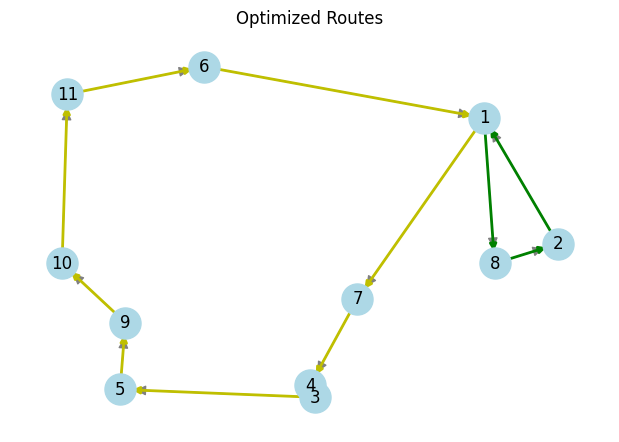

In [30]:
nodes_list = list(range(1, 12))
main_depot = 1
demand_values = {1: 0, 2: 19, 3: 21, 4: 6, 5: 19, 6: 7, 7: 12, 8: 16, 9: 6, 10: 16, 11: 8}
max_capacity = 100
node_positions = {
    1: (82, 76), 2: (96, 44), 3: (50, 5), 4: (49, 8), 5: (13, 7),
    6: (29, 89), 7: (58, 30), 8: (84, 39), 9: (14, 24), 10: (2, 39), 11: (3, 82)
}

def compute_distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

distance_matrix = {(i, j): compute_distance(node_positions[i], node_positions[j]) for i in nodes_list for j in nodes_list if i != j}

opt_model = ConcreteModel()
opt_model.route = Var(nodes_list, nodes_list, domain=Binary)
opt_model.load_var = Var(nodes_list, within=NonNegativeReals)

opt_model.total_dist = Objective(expr=sum(distance_matrix[i, j] * opt_model.route[i, j] for i in nodes_list for j in nodes_list if i != j), sense=minimize)

opt_model.cons_set = ConstraintList()

for j in nodes_list:
    if j != main_depot:
        opt_model.cons_set.add(sum(opt_model.route[i, j] for i in nodes_list if i != j) == 1)

for i in nodes_list:
    if i != main_depot:
        opt_model.cons_set.add(sum(opt_model.route[i, j] for j in nodes_list if i != j) == 1)

for h in nodes_list:
    if h != main_depot:
        opt_model.cons_set.add(sum(opt_model.route[i, h] for i in nodes_list if i != h) == sum(opt_model.route[h, j] for j in nodes_list if h != j))

for i in nodes_list:
    for j in nodes_list:
        if i != j and i != main_depot and j != main_depot:
            opt_model.cons_set.add(opt_model.load_var[i] - opt_model.load_var[j] + max_capacity * opt_model.route[i, j] <= max_capacity - demand_values[j])

for i in nodes_list:
    if i != main_depot:
        opt_model.cons_set.add(opt_model.load_var[i] >= demand_values[i])
        opt_model.cons_set.add(opt_model.load_var[i] <= max_capacity)

solver_obj = SolverFactory('glpk', executable='/usr/bin/glpsol')
solver_obj.solve(opt_model)

optimal_routes = [(i, j) for i in nodes_list for j in nodes_list if i != j and opt_model.route[i, j].value > 0.5]

route_paths = []
visited_nodes = set()
for src, dst in optimal_routes:
    if src == main_depot and src not in visited_nodes:
        path = [src]
        while dst != main_depot:
            path.append(dst)
            visited_nodes.add(dst)
            next_step = [j for i, j in optimal_routes if i == dst and j not in visited_nodes]
            if next_step:
                dst = next_step[0]
            else:
                break
        path.append(main_depot)
        route_paths.append(path)

print("Optimal path:")
for path in route_paths:
    print(" => ".join(map(str, path)))
print(f"Total Travel Distance: {sum(distance_matrix[i, j] for i, j in optimal_routes):.2f}")


plt.figure(figsize=(6, 4))
graph_net = nx.DiGraph()
for i in nodes_list:
    graph_net.add_node(i, pos=node_positions[i])
for i, j in optimal_routes:
    graph_net.add_edge(i, j)

node_positions_map = nx.get_node_attributes(graph_net, 'pos')
nx.draw(graph_net, node_positions_map, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray', arrowsize=15)

color_list = ['y', 'g', 'b', 'c', 'm', 'r']
for idx, path in enumerate(route_paths):
    route_color = color_list[idx % len(color_list)]
    edges_to_draw = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    nx.draw_networkx_edges(graph_net, node_positions_map, edgelist=edges_to_draw, edge_color=route_color, width=2)

plt.title("Optimized Routes")
plt.xlabel("X Coord")
plt.ylabel("Y Coord")
plt.show()

## Ques 2

In [33]:
node_coords = {
    1: (82, 76), 2: (96, 44), 3: (50, 5), 4: (49, 8), 5: (13, 7),
    6: (29, 89), 7: (58, 30), 8: (84, 39), 9: (14, 24), 10: (2, 39),
    11: (3, 82), 12: (5, 10), 13: (98, 52)
}

demands = {
    1: 0, 2: 19, 3: 21, 4: 6, 5: 19,
    6: 7, 7: 12, 8: 16, 9: 6, 10: 16,
    11: 8, 12: 14, 13: 21
}

capacity = 100
depot = 1

def solve_vrp(num_nodes, capacity, full_coords, full_demands):
    nodes = list(range(1, num_nodes + 1))
    coordinates = {i: full_coords[i] for i in nodes}
    demands = {i: full_demands[i] for i in nodes}

    def euclidean_distance(coord1, coord2):
        return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

    distance = {(i, j): euclidean_distance(coordinates[i], coordinates[j])
                for i in nodes for j in nodes if i != j}

    model = ConcreteModel()
    model.x = Var(nodes, nodes, domain=Binary)
    model.u = Var(nodes, within=NonNegativeReals)

    model.obj = Objective(expr=sum(distance[i, j] * model.x[i, j]
                                  for i in nodes for j in nodes if i != j),
                          sense=minimize)

    model.constraints = ConstraintList()

    for j in nodes:
        if j != depot:
            model.constraints.add(sum(model.x[i, j] for i in nodes if i != j) == 1)

    for i in nodes:
        if i != depot:
            model.constraints.add(sum(model.x[i, j] for j in nodes if i != j) == 1)

    for h in nodes:
        if h != depot:
            model.constraints.add(sum(model.x[i, h] for i in nodes if i != h) ==
                                  sum(model.x[h, j] for j in nodes if h != j))

    for i in nodes:
        for j in nodes:
            if i != j and i != depot and j != depot:
                model.constraints.add(model.u[i] - model.u[j] + capacity * model.x[i, j] <= capacity - demands[j])

    for i in nodes:
        if i != depot:
            model.constraints.add(model.u[i] >= demands[i])
            model.constraints.add(model.u[i] <= capacity)

    solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
    start_time = time.time()
    solver.solve(model)
    elapsed_time = time.time() - start_time

    solution = [(i, j) for i in nodes for j in nodes
                if i != j and value(model.x[i, j]) > 0.5]
    total_distance = sum(distance[i, j] for i, j in solution)

    return total_distance, elapsed_time

if __name__ == '__main__':
    for num in [11, 12, 13]:
        total_distance, solution_time = solve_vrp(num, capacity, node_coords, demands)
        print(f"Demand Points: {num}")
        print(f"  Total Distance (Objective Value): {total_distance:.2f}")
        print(f"  Solution Time: {solution_time:.2f} seconds")
        print("-" * 40)


Demand Points: 11
  Total Distance (Objective Value): 361.60
  Solution Time: 0.96 seconds
----------------------------------------
Demand Points: 12
  Total Distance (Objective Value): 412.03
  Solution Time: 20.62 seconds
----------------------------------------
Demand Points: 13
  Total Distance (Objective Value): 414.19
  Solution Time: 55.76 seconds
----------------------------------------


## Ques 3

In [44]:
# A-n32-k5 instance data
an32_coords = {
    1: (82,76),  2: (96,44),  3: (50,5),   4: (49,8),
    5: (13,7),   6: (29,89),  7: (58,30),  8: (84,39),
    9: (14,24),  10: (2,39),  11: (3,82),  12: (5,10),
    13: (98,52), 14: (84,25), 15: (61,59), 16: (1,65),
    17: (88,51), 18: (91,2),  19: (19,32), 20: (93,3),
    21: (50,93), 22: (98,14), 23: (5,42),  24: (42,9),
    25: (61,62), 26: (9,97),  27: (80,55), 28: (57,69),
    29: (23,15), 30: (20,70), 31: (85,60), 32: (98,5)
}
an32_demands = {
    1: 0,  2: 19, 3: 21,  4: 6,   5: 19,  6: 7,
    7: 12, 8: 16, 9: 6,   10: 16, 11: 8,  12: 14,
    13: 21, 14: 16, 15: 3,  16: 22, 17: 18, 18: 19,
    19: 1,  20: 24, 21: 8,  22: 12, 23: 4,  24: 8,
    25: 24, 26: 24, 27: 2,  28: 20, 29: 15, 30: 2,
    31: 14, 32: 9
}

# A-n80-k10 instance data
an80_coords = {
    1: (92,92),  2: (88,58),  3: (70,6),   4: (57,59),
    5: (0,98),   6: (61,38),  7: (65,22),  8: (91,52),
    9: (59,2),   10: (3,54),  11: (95,38), 12: (80,28),
    13: (66,42), 14: (79,74), 15: (99,25), 16: (20,43),
    17: (40,3),  18: (50,42), 19: (97,0),  20: (21,19),
    21: (36,21), 22: (100,61),23: (11,85), 24: (69,35),
    25: (69,22), 26: (29,35), 27: (14,9),  28: (50,33),
    29: (89,17), 30: (57,44), 31: (60,25), 32: (48,42),
    33: (17,93), 34: (21,50), 35: (77,18), 36: (2,4),
    37: (63,83), 38: (68,6),  39: (41,95), 40: (48,54),
    41: (98,73), 42: (26,38), 43: (69,76), 44: (40,1),
    45: (65,41), 46: (14,86), 47: (32,39), 48: (14,24),
    49: (96,5),  50: (82,98), 51: (23,85), 52: (63,69),
    53: (87,19), 54: (56,75), 55: (15,63), 56: (10,45),
    57: (7,30),  58: (31,11), 59: (36,93), 60: (50,31),
    61: (49,52), 62: (39,10), 63: (76,40), 64: (83,34),
    65: (33,51), 66: (0,15),  67: (52,82), 68: (52,82),
    69: (46,6),  70: (3,26),  71: (46,80), 72: (94,30),
    73: (26,76), 74: (75,92), 75: (57,51), 76: (34,21),
    77: (28,80), 78: (59,66), 79: (51,16), 80: (87,11)
}
an80_demands = {
    1: 0,  2: 24,  3: 22,  4: 23,  5: 5,   6: 11,  7: 23,  8: 26,
    9: 9,  10: 23, 11: 9,   12: 14, 13: 16, 14: 12, 15: 2,   16: 2,
    17: 6,  18: 20, 19: 26,  20: 12, 21: 15, 22: 13, 23: 26,  24: 17,
    25: 7,  26: 12, 27: 4,   28: 4,  29: 20, 30: 10, 31: 9,   32: 2,
    33: 9,  34: 1,  35: 2,   36: 2,  37: 12, 38: 14, 39: 23,  40: 21,
    41: 13, 42: 13, 43: 23,  44: 3,  45: 6,   46: 23, 47: 11,  48: 2,
    49: 7,  50: 13, 51: 10,  52: 3,  53: 6,   54: 13, 55: 2,   56: 14,
    57: 7,  58: 21, 59: 7,   60: 22, 61: 13, 62: 22, 63: 18,  64: 22,
    65: 6,  66: 2,  67: 11,  68: 5,  69: 9,   70: 9,  71: 5,   72: 12,
    73: 2,  74: 12, 75: 19,  76: 6,  77: 14,  78: 2,  79: 2,   80: 24
}

Simulated Annealing on A-n32-k5
[A-n32-k5] Init Temp: 100.00 | Best Cost:   811.17 | Gap:   3.47% | Time:   0.21 sec
[A-n32-k5] Init Temp: 200.00 | Best Cost:   960.83 | Gap:  22.56% | Time:   0.22 sec
[A-n32-k5] Init Temp: 300.00 | Best Cost:   837.02 | Gap:   6.76% | Time:   0.21 sec
[A-n32-k5] Init Temp: 400.00 | Best Cost:   861.85 | Gap:   9.93% | Time:   0.22 sec
[A-n32-k5] Init Temp: 500.00 | Best Cost:   817.26 | Gap:   4.24% | Time:   0.20 sec
[A-n32-k5] Init Temp: 600.00 | Best Cost:   875.94 | Gap:  11.73% | Time:   0.22 sec
[A-n32-k5] Init Temp: 700.00 | Best Cost:   838.64 | Gap:   6.97% | Time:   0.21 sec
[A-n32-k5] Init Temp: 800.00 | Best Cost:   867.44 | Gap:  10.64% | Time:   0.21 sec
[A-n32-k5] Init Temp: 900.00 | Best Cost:   843.14 | Gap:   7.54% | Time:   0.21 sec
[A-n32-k5] Init Temp: 1000.00 | Best Cost:   820.46 | Gap:   4.65% | Time:   0.21 sec

Simulated Annealing on A-n80-k10
[A-n80-k10] Init Temp: 100.00 | Best Cost:  2102.03 | Gap:  19.23% | Time:   0.47 s

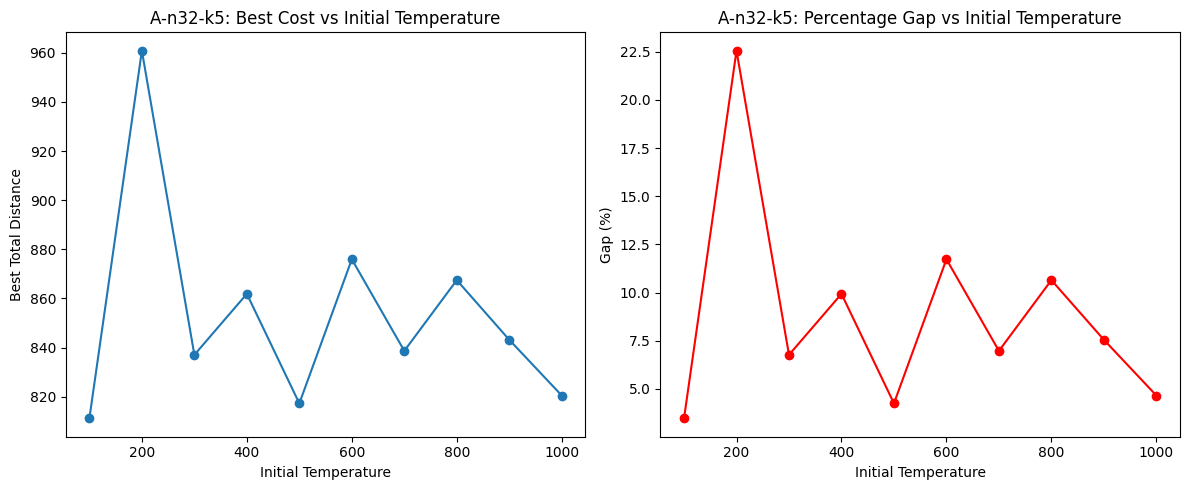

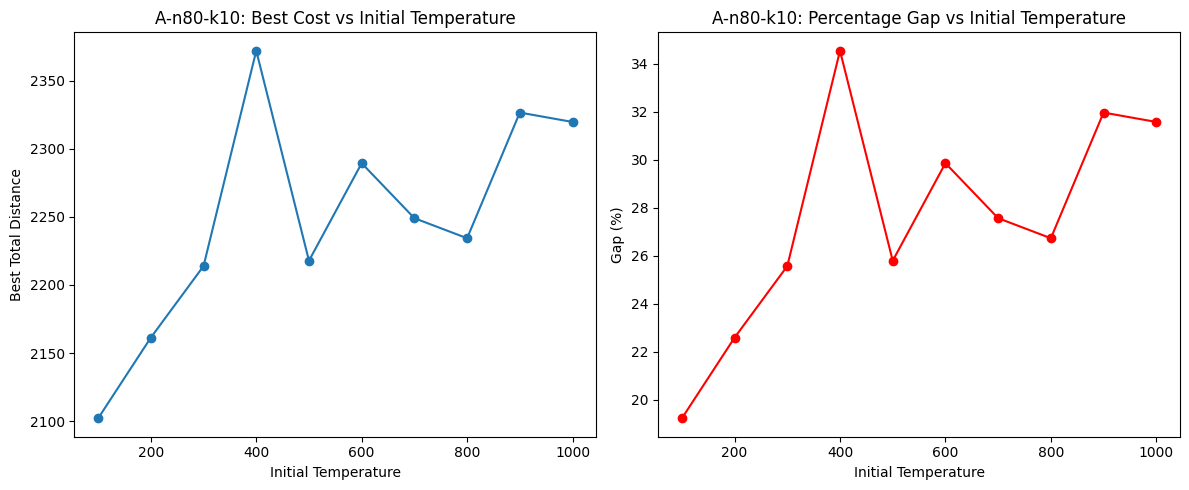

In [51]:
CAPACITY = 100
DEPOT = 1

optimal_values = {'A-n32-k5': 784, 'A-n80-k10': 1763}

def euclidean_distance(p, q):
    return math.sqrt((p[0]-q[0])**2 + (p[1]-q[1])**2)

def split_routes(permutation, demands, capacity):
    routes = []
    current_route = [DEPOT]
    current_load = 0
    for customer in permutation:
        demand = demands[customer]
        if current_load + demand <= capacity:
            current_route.append(customer)
            current_load += demand
        else:
            current_route.append(DEPOT)
            routes.append(current_route)
            current_route = [DEPOT, customer]
            current_load = demand
    current_route.append(DEPOT)
    routes.append(current_route)
    return routes

def total_distance(routes, coords):
    total = 0.0
    for route in routes:
        for i in range(len(route)-1):
            total += euclidean_distance(coords[route[i]], coords[route[i+1]])
    return total

def solve_vrp_sa(instance_name, coords, demands, capacity, init_temp, alpha, max_iter):
    customers = list(coords.keys())
    customers.remove(DEPOT)
    current_perm = customers[:]
    random.shuffle(current_perm)
    current_routes = split_routes(current_perm, demands, capacity)
    current_cost = total_distance(current_routes, coords)
    best_perm = current_perm[:]
    best_cost = current_cost
    T = init_temp
    start_time = time.time()
    for _ in range(max_iter):
        neighbor_perm = current_perm[:]
        if random.random() < 0.5:
            i, j = random.sample(range(len(customers)), 2)
            neighbor_perm[i], neighbor_perm[j] = neighbor_perm[j], neighbor_perm[i]
        else:
            i, j = sorted(random.sample(range(len(customers)), 2))
            neighbor_perm[i:j+1] = reversed(neighbor_perm[i:j+1])
        neighbor_routes = split_routes(neighbor_perm, demands, capacity)
        neighbor_cost = total_distance(neighbor_routes, coords)
        delta = neighbor_cost - current_cost
        if delta < 0 or math.exp(-delta / T) > random.random():
            current_perm = neighbor_perm
            current_cost = neighbor_cost
            if current_cost < best_cost:
                best_cost = current_cost
                best_perm = current_perm[:]
        T *= alpha
        if T < 1e-3:
            break
    elapsed_time = time.time() - start_time
    best_routes = split_routes(best_perm, demands, capacity)
    return best_cost, best_routes, elapsed_time

def run_experiment(instance_name, coords, demands, capacity, optimal, init_temps, alpha, max_iter):
    best_results = []
    for init_temp in init_temps:
        cost, routes, ttime = solve_vrp_sa(instance_name, coords, demands, capacity, init_temp, alpha, max_iter)
        gap = ((cost - optimal) / optimal) * 100
        best_results.append((init_temp, cost, gap, ttime))
        print(f"[{instance_name}] Init Temp: {init_temp:6.2f} | Best Cost: {cost:8.2f} | Gap: {gap:6.2f}% | Time: {ttime:6.2f} sec")
    return best_results

if __name__ == '__main__':
    random.seed(42)
    max_iter = 10000
    alpha = 0.999
    init_temps = list(range(100, 1001, 100))
    print("Simulated Annealing on A-n32-k5")
    results_an32 = run_experiment("A-n32-k5", an32_coords, an32_demands, CAPACITY, optimal_values['A-n32-k5'], init_temps, alpha, max_iter)
    print("\nSimulated Annealing on A-n80-k10")
    results_an80 = run_experiment("A-n80-k10", an80_coords, an80_demands, CAPACITY, optimal_values['A-n80-k10'], init_temps, alpha, max_iter)
    temps_an32 = [res[0] for res in results_an32]
    costs_an32 = [res[1] for res in results_an32]
    gaps_an32 = [res[2] for res in results_an32]
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(temps_an32, costs_an32, marker='o')
    ax[0].set_title("A-n32-k5: Best Cost vs Initial Temperature")
    ax[0].set_xlabel("Initial Temperature")
    ax[0].set_ylabel("Best Total Distance")
    ax[1].plot(temps_an32, gaps_an32, marker='o', color='red')
    ax[1].set_title("A-n32-k5: Percentage Gap vs Initial Temperature")
    ax[1].set_xlabel("Initial Temperature")
    ax[1].set_ylabel("Gap (%)")
    plt.tight_layout()
    plt.show()
    temps_an80 = [res[0] for res in results_an80]
    costs_an80 = [res[1] for res in results_an80]
    gaps_an80 = [res[2] for res in results_an80]
    fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5))
    ax2[0].plot(temps_an80, costs_an80, marker='o')
    ax2[0].set_title("A-n80-k10: Best Cost vs Initial Temperature")
    ax2[0].set_xlabel("Initial Temperature")
    ax2[0].set_ylabel("Best Total Distance")
    ax2[1].plot(temps_an80, gaps_an80, marker='o', color='red')
    ax2[1].set_title("A-n80-k10: Percentage Gap vs Initial Temperature")
    ax2[1].set_xlabel("Initial Temperature")
    ax2[1].set_ylabel("Gap (%)")
    plt.tight_layout()
    plt.show()


## Ques 4

In [50]:
CAPACITY = 100
DEPOT = 1

optimal_values = {'A-n32-k5': 784, 'A-n80-k10': 1763}

def euclidean_distance(p, q):
    return math.sqrt((p[0]-q[0])**2 + (p[1]-q[1])**2)

def split_routes(permutation, demands, capacity):
    routes = []
    current_route = [DEPOT]
    current_load = 0
    for customer in permutation:
        demand = demands[customer]
        if current_load + demand <= capacity:
            current_route.append(customer)
            current_load += demand
        else:
            current_route.append(DEPOT)
            routes.append(current_route)
            current_route = [DEPOT, customer]
            current_load = demand
    current_route.append(DEPOT)
    routes.append(current_route)
    return routes

def total_distance(routes, coords):
    total = 0.0
    for route in routes:
        for i in range(len(route)-1):
            total += euclidean_distance(coords[route[i]], coords[route[i+1]])
    return total

def initialize_population(pop_size, customers):
    population = []
    for _ in range(pop_size):
        perm = customers[:]
        random.shuffle(perm)
        population.append(perm)
    return population

def evaluate_population(population, coords, demands, capacity):
    evaluated = []
    for perm in population:
        routes = split_routes(perm, demands, capacity)
        cost = total_distance(routes, coords)
        fit = 1 / (1 + cost)
        evaluated.append((perm, cost, fit))
    return evaluated

def tournament_selection(evaluated, tournament_size=5):
    participants = random.sample(evaluated, tournament_size)
    participants.sort(key=lambda x: x[2], reverse=True)
    return participants[0][0][:]

def ordered_crossover(parent1, parent2):
    size = len(parent1)
    child = [None] * size
    a, b = sorted(random.sample(range(size), 2))
    child[a:b+1] = parent1[a:b+1]
    pos = (b + 1) % size
    for gene in parent2:
        if gene not in child:
            child[pos] = gene
            pos = (pos + 1) % size
    return child

def swap_mutation(perm, mutation_rate=0.15):
    perm = perm[:]
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(perm)), 2)
        perm[i], perm[j] = perm[j], perm[i]
    return perm

def genetic_algorithm(coords, demands, capacity, pop_size, generations, mutation_rate, elite_size):
    customers = list(coords.keys())
    customers.remove(DEPOT)
    population = initialize_population(pop_size, customers)
    best_solution = None
    best_cost = float('inf')
    start_time = time.time()
    for gen in range(generations):
        evaluated = evaluate_population(population, coords, demands, capacity)
        evaluated.sort(key=lambda x: x[1])
        elites = [x[0] for x in evaluated[:elite_size]]
        if evaluated[0][1] < best_cost:
            best_cost = evaluated[0][1]
            best_solution = evaluated[0][0][:]
        new_population = elites[:]
        while len(new_population) < pop_size:
            parent1 = tournament_selection(evaluated, tournament_size=5)
            parent2 = tournament_selection(evaluated, tournament_size=5)
            child = ordered_crossover(parent1, parent2)
            child = swap_mutation(child, mutation_rate)
            new_population.append(child)
        population = new_population
    elapsed_time = time.time() - start_time
    best_routes = split_routes(best_solution, demands, capacity)
    return best_cost, best_routes, elapsed_time

def run_ga_experiment(instance_name, coords, demands, capacity, optimal, pop_size, generations, mutation_rate, elite_size):
    print(f"Running Genetic Algorithm on {instance_name}")
    best_cost, best_routes, elapsed_time = genetic_algorithm(coords, demands, capacity, pop_size, generations, mutation_rate, elite_size)
    gap = ((best_cost - optimal) / optimal) * 100
    print(f"[{instance_name}] Best Cost: {best_cost:8.2f} | Gap: {gap:6.2f}% | Time: {elapsed_time:6.2f} sec")
    return best_cost, best_routes, gap, elapsed_time

if __name__ == '__main__':
    random.seed(42)
    pop_size = 100
    generations = 5000
    mutation_rate = 0.15
    elite_size = 10
    print("Genetic Algorithm on A-n32-k5")
    ga_results_an32 = run_ga_experiment("A-n32-k5", an32_coords, an32_demands, CAPACITY, optimal_values['A-n32-k5'], pop_size, generations, mutation_rate, elite_size)
    print("\nGenetic Algorithm on A-n80-k10")
    ga_results_an80 = run_ga_experiment("A-n80-k10", an80_coords, an80_demands, CAPACITY, optimal_values['A-n80-k10'], pop_size, generations, mutation_rate, elite_size)


Genetic Algorithm on A-n32-k5
Running Genetic Algorithm on A-n32-k5
[A-n32-k5] Best Cost:   834.89 | Gap:   6.49% | Time:  22.23 sec

Genetic Algorithm on A-n80-k10
Running Genetic Algorithm on A-n80-k10
[A-n80-k10] Best Cost:  2194.16 | Gap:  24.46% | Time:  64.86 sec


## Ques 5

In [20]:
!pip install ortools

In [47]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import math

CAPACITY = 100
vehicles_an32 = 5
vehicles_an80 = 10
DEPOT = 1

def euclidean_distance(p, q):
    return math.hypot(p[0] - q[0], p[1] - q[1])

def create_distance_matrix(coords):
    size = len(coords)
    matrix = [[0] * size for _ in range(size)]
    for i in range(1, size+1):
        for j in range(1, size+1):
            if i != j:
                matrix[i-1][j-1] = int(euclidean_distance(coords[i], coords[j]) + 0.5)
    return matrix

def solve_vrp_ortools(coords, demands, vehicle_count, capacity):
    distance_matrix = create_distance_matrix(coords)
    demand_list = [demands[i] for i in range(1, len(coords)+1)]
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), vehicle_count, DEPOT-1)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return demand_list[from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimension(demand_callback_index, 0, capacity, True, 'Capacity')

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_parameters.time_limit.FromSeconds(30)

    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        total_distance = solution.ObjectiveValue()
        routes = []
        for vehicle_id in range(vehicle_count):
            index = routing.Start(vehicle_id)
            route = []
            while not routing.IsEnd(index):
                node = manager.IndexToNode(index)
                route.append(node + 1)
                index = solution.Value(routing.NextVar(index))
            route.append(DEPOT)
            routes.append(route)
        return routes, total_distance
    else:
        return None, None

def main():
    print("Solving VRP with OR-Tools for A-n32-k5 instance")
    routes_an32, total_dist_an32 = solve_vrp_ortools(an32_coords, an32_demands, vehicles_an32, CAPACITY)
    if routes_an32:
        print("A-n32-k5 Routes:")
        for idx, route in enumerate(routes_an32):
            print(f" Vehicle {idx+1}: {route}")
        print(f"Total Distance: {total_dist_an32}")
    else:
        print("No solution found for A-n32-k5")

    print("\nSolving VRP with OR-Tools for A-n80-k10 instance")
    routes_an80, total_dist_an80 = solve_vrp_ortools(an80_coords, an80_demands, vehicles_an80, CAPACITY)
    if routes_an80:
        print("A-n80-k10 Routes:")
        for idx, route in enumerate(routes_an80):
            print(f" Vehicle {idx+1}: {route}")
        print(f"Total Distance: {total_dist_an80}")
    else:
        print("No solution found for A-n80-k10")

if __name__ == '__main__':
    main()


Solving VRP with OR-Tools for A-n32-k5 instance
A-n32-k5 Routes:
 Vehicle 1: [1, 25, 28, 1]
 Vehicle 2: [1, 31, 17, 2, 13, 1]
 Vehicle 3: [1, 21, 6, 26, 11, 16, 23, 10, 9, 19, 30, 1]
 Vehicle 4: [1, 27, 8, 14, 18, 20, 32, 22, 1]
 Vehicle 5: [1, 15, 29, 12, 5, 24, 4, 3, 7, 1]
Total Distance: 784

Solving VRP with OR-Tools for A-n80-k10 instance
A-n80-k10 Routes:
 Vehicle 1: [1, 73, 55, 10, 56, 57, 70, 66, 36, 27, 20, 48, 42, 16, 34, 1]
 Vehicle 2: [1, 13, 45, 6, 60, 28, 18, 30, 1]
 Vehicle 3: [1, 24, 31, 79, 62, 21, 26, 47, 65, 78, 52, 1]
 Vehicle 4: [1, 37, 67, 68, 71, 77, 59, 39, 50, 1]
 Vehicle 5: [1, 11, 72, 29, 80, 19, 49, 15, 1]
 Vehicle 6: [1, 14, 63, 7, 25, 12, 64, 1]
 Vehicle 7: [1, 43, 4, 40, 61, 75, 1]
 Vehicle 8: [1, 53, 35, 3, 38, 9, 69, 44, 17, 58, 76, 32, 1]
 Vehicle 9: [1, 41, 22, 8, 2, 1]
 Vehicle 10: [1, 54, 51, 46, 23, 5, 33, 74, 1]
Total Distance: 1810


## Comparison of VRP Solutions: OR-Tools vs. Simulated Annealing vs. Genetic Algorithm

### 1. Solution Comparison

| **Method**             | **A-n32-k5 Best Cost** | **Gap from Optimum (784)** | **Time Taken**      | **A-n80-k10 Best Cost** | **Gap from Optimum (1763)** | **Time Taken**      |
|------------------------|------------------------|----------------------------|---------------------|-------------------------|----------------------------|---------------------|
| **OR-Tools**           | **784**                | **0.00%**                  | *Up to 120 sec*     | **1810**                | **~2.66%**                 | *Up to 120 sec*     |
| **Simulated Annealing**| 811.17                 | 3.47%                      | ~0.21 sec (A-n32)   | 2102.03                 | 19.23%                     | ~0.47 sec (A-n80)   |
| **Genetic Algorithm**  | 834.89                 | 6.49%                      | ~22.23 sec (A-n32)  | 2194.16                 | 24.46%                     | ~64.86 sec (A-n80)  |

---

### 2. Observations

- **OR-Tools**:
  - Achieved the **optimal solution** for A‑n32‑k5 (cost = 784).
  - For A‑n80‑k10, it reached a near-optimal solution with a cost of 1810 (gap ≈ 2.66%).
  - Utilizes advanced local search methods and efficient constraint handling.

- **Simulated Annealing**:
  - Fastest in terms of computation time.
  - However, produced higher cost gaps (≈ 3.47% for A‑n32‑k5 and ≈ 19.23% for A‑n80‑k10).

- **Genetic Algorithm**:
  - Took significantly longer.
  - Delivered solutions with larger gaps (≈ 6.49% for A‑n32‑k5 and ≈ 24.46% for A‑n80‑k10).

---

### 3. Why Did OR-Tools Perform Better?

- **Advanced Local Search Methods**:  
  OR-Tools employs *Guided Local Search (GLS)* which penalizes frequently used routes to promote better exploration and convergence.

- **Better Initial Solutions**:  
  The solver starts with a strong initial solution generated by the *PATH_CHEAPEST_ARC* heuristic, while SA and GA typically begin from random or near-random solutions.

- **Efficient Constraint Handling**:  
  OR-Tools natively supports VRP constraints (e.g., capacity, demand), leading to more efficient and effective search compared to the indirect methods required in SA and GA.

- **Deterministic and Metaheuristic Search**:  
  OR-Tools combines deterministic branch-and-bound techniques with metaheuristics, ensuring higher-quality solutions when provided sufficient time.

- **Longer Computation Time Allowed**:  
  With a time limit of 120 seconds, OR-Tools has more opportunity to explore the solution space thoroughly and converge to an optimal or near-optimal solution.

---

